In [14]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs
from numpyro.infer.initialization import init_to_value, init_to_feasible

from jax import numpy as jnp
from jax import random

import re 

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import siuba as s
from siuba import _

%run -i 'model_helpers.py'
%run -i 'models.py'

In [15]:

df = pd.read_csv("data/exp2-passing.csv")
# rng = np.random.default_rng(123)
# df = df >> s.filter(_.pass_check==1) >> s.mutate(response = _.response.replace({0:.001, 1:.999}))
# df = df >> s.filter(_.pass_check==1) #, _.response > 0.0, _.response < 1.0)
df = (df >> 
    s.mutate(
        response = _.response.replace({0:.01, 1:.99}),
        condition = s.case_when({
            _.condition=="coldrainy_london": 0,
            _.condition=="sunnywarm_london": 1,
            _.condition=="coldrainy_yourzip": 2,
            _.condition=="sunnywarm_yourzip": 3
        })
    )
)

# df["response"] = rng.beta(df.response*25, (1-df.response)*25)
print(df.shape)
df.head()

(7520, 13)


,ID,age,gender,race,zip,StartDate,duration,pass_check,response,querytype,weather_cond,location_cond,condition
0,0,35.0,Man,White,99568.0,2021-06-25T10:01:18Z,519,1,0.3,A,coldrainy,london,0
1,1,38.0,Woman,Asian,32301.0,2021-06-25T10:04:31Z,440,1,0.3,A,coldrainy,london,0
2,2,55.0,Man,White,97333.0,2021-06-25T10:01:17Z,640,1,0.5,A,coldrainy,london,0
3,3,47.0,Man,Black or African American,28312.0,2021-06-25T10:06:58Z,373,1,0.6,A,coldrainy,london,0
4,4,46.0,Woman,White,72653.0,2021-06-25T10:01:48Z,686,1,0.6,A,coldrainy,london,0


In [17]:
X_data, y_data = make_model_data(df) # see data_helpers.py
print(len(y_data))
print(min(y_data), max(y_data))

7520
0.01 0.99


In [18]:
def hybrid_model_heterogeneity(data, y=None):
    # an alternate version of PT+N that treats conditional probabilties like simple probabilities
    # equivalently, a Bayesian Sampler allowing beta parameter in [0, inf]

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter
    
    # condition-level parameters
    with numpyro.plate("conds_pop", n_conds):
        d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
        d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
        d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
        d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    # subject-level parameters/priors 
    # with numpyro.plate("subj", n_Ps):
    #     d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
    #     d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
    
    
    subjcond_ind = subj*n_conds + cond
    d_lin = (d_base_pop[cond] + 
             d_bases[subjcond_ind]*d_base_sd[cond] + 
             jnp.exp(d_delta_pop[cond] + d_delta_sd[cond]*d_deltas[subjcond_ind])*conjdisj
            )  # exp() constrains d_delta to be positive
    d = sigmoid(d_lin)/2.0 # require this be in [0, .50]
    
    # deterministic sites
    numpyro.deterministic("d_subjcond", sigmoid(d_base_pop[cond] + d_bases[subjcond_ind]*d_base_sd[cond])/2.)
    numpyro.deterministic("d_prime_subjcond", 
                          sigmoid(d_base_pop[cond] + d_bases[subjcond_ind]*d_base_sd[cond] + 
                                  jnp.exp(d_delta_pop[cond] + d_deltas[subjcond_ind]*d_delta_sd[cond])
                                 )/2.)
    
    # theta_ind = (subj*n_conds) + cond
    theta = thetas[subjcond_ind,:]
    
    p_ptn = calc_ptn_prob(calc_prob(theta, X_num, X_denom), d)

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [19]:
mcmc_test = MCMC(NUTS(hybrid_model_heterogeneity, target_accept_prob=.90), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_test.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [58]:
az_test = make_arviz_data(mcmc_test, hybrid_model_heterogeneity, X_data) # see model_helpers.py

Participant mean response corr =  0.743
Query-level corr 0.898


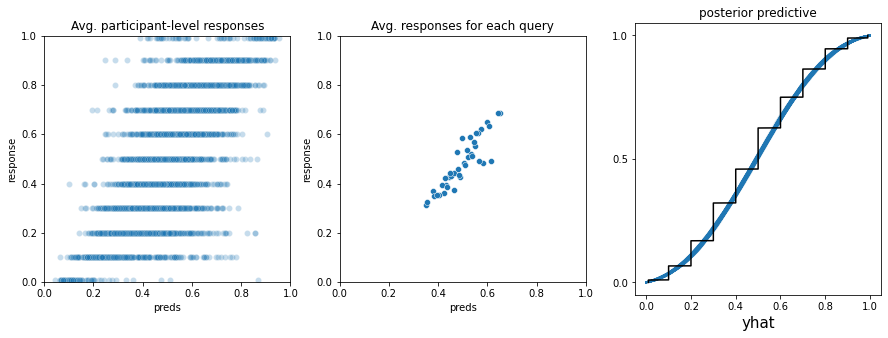

In [59]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response, alpha=.25)

    trial_df = (d[d["location_cond"]=="london"]
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"yhat":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")
    
plot_model_preds(df, az_test)

array([<AxesSubplot:title={'center':'d_base_pop\n0'}>,
       <AxesSubplot:title={'center':'d_base_pop\n1'}>,
       <AxesSubplot:title={'center':'d_base_pop\n2'}>,
       <AxesSubplot:title={'center':'d_base_pop\n3'}>], dtype=object)

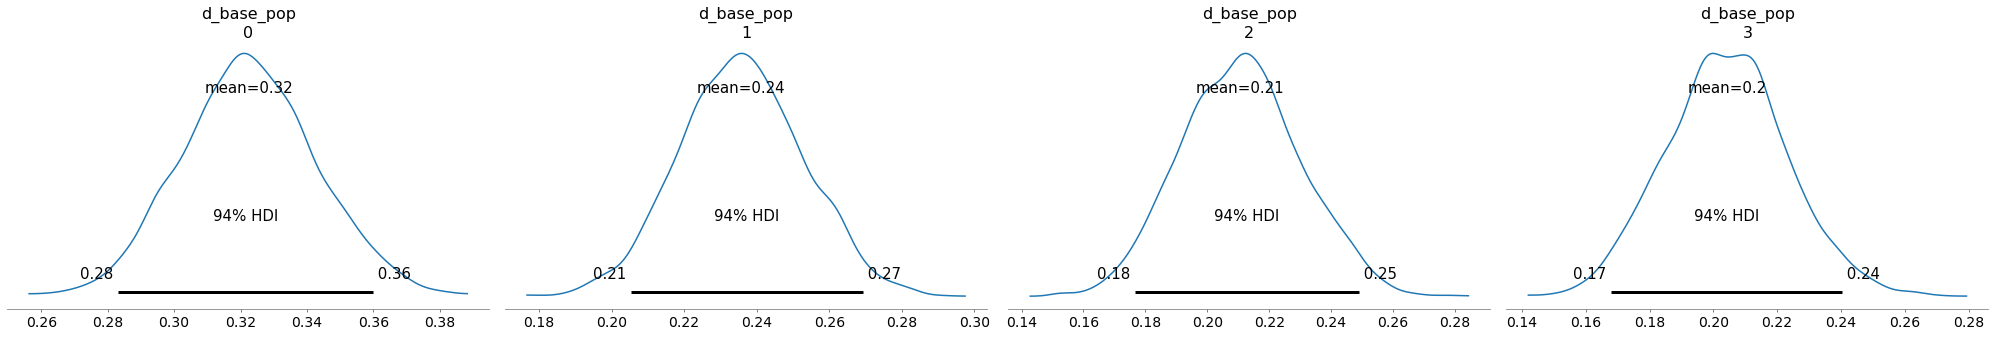

In [60]:
az.plot_posterior(az_test, var_names = ["d_base_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2.)

array([<AxesSubplot:title={'center':'d_prime_pop\n0'}>,
       <AxesSubplot:title={'center':'d_prime_pop\n1'}>,
       <AxesSubplot:title={'center':'d_prime_pop\n2'}>,
       <AxesSubplot:title={'center':'d_prime_pop\n3'}>], dtype=object)

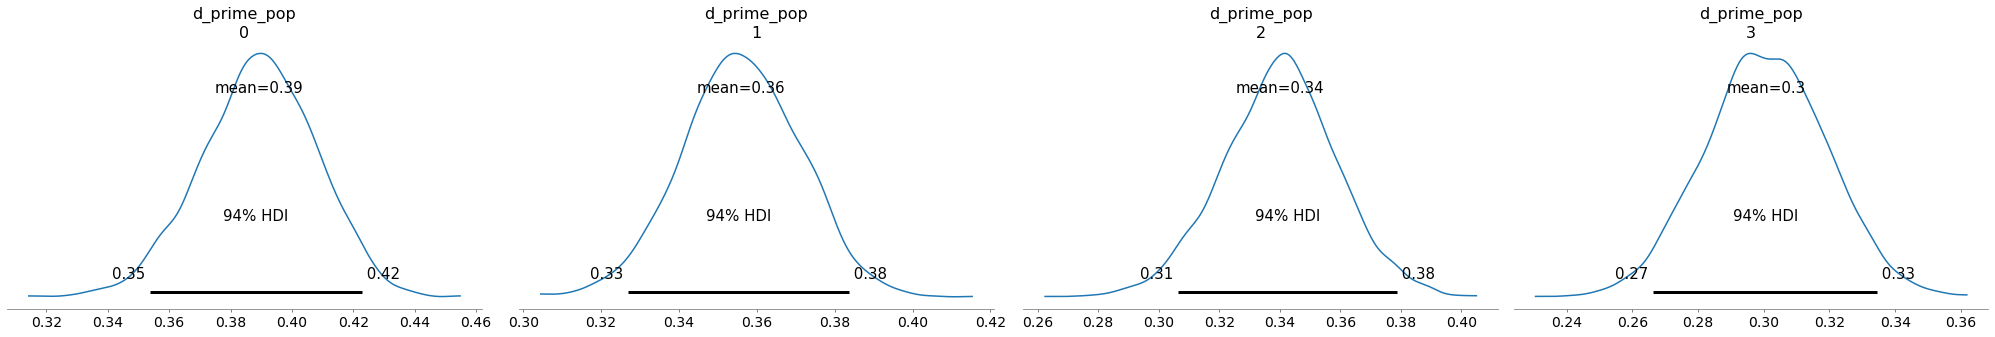

In [61]:
import xarray as xr
x = az_test.posterior.d_base_pop.values + np.exp(az_test.posterior.d_delta_pop.values)
az_test.posterior["d_prime_pop"] = xr.DataArray(x, 
                                                coords = {"chain": [0,1,2,3] ,
                                                               "draw": az_test.posterior.d_base_pop.draw.values, 
                                                               "d_prime_pop_dim_0": [0,1,2,3]},
                                                dims=["chain","draw","d_prime_pop_dim_0"])

az.plot_posterior(az_test, var_names = ["d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2.)

These are possibly different, will need some more careful analyses to really determine. It is clear they are less different than London vs Los Angeles in Experiment 1. So, it sort of hurts the idea that knowing about something from experience would cause a really strong difference. Course it could be that Los Angeles' weather is both very well known and predictable so that it is a sort of special case.

In [95]:
d_base_posterior = np.array(az_test.posterior.d_base_pop.stack(draws=("chain","draw")))
post1 = np.concatenate((d_base_posterior[0,:], d_base_posterior[1,:]))
post2 = np.concatenate((d_base_posterior[2,:], d_base_posterior[3,:]))

def compare_posterior(x1, x2):
    np.random.shuffle(x1)
    np.random.shuffle(x2)
    return np.mean(x1 > x2)

compare_posterior(post1, post2)

0.927125

Somewhat less clear result here that the $d$ values for questions about London weather are higher than for weather where participants live. Generally not at the level of confidence I'd want to make confident claims.

What to do now:
